# Exercise 2: Stream

### Input files needed:
- topography.csv - grid of land surface elevations 
- watershed.csv - grid of no-flow cells indicating the watershed boundary

### MODFLOW packages used:
- DIS - Discretization input
- BAS - Basic
- LPF - Layer-Property Flow
- OC  - Output Control
- PCG - Preconditioned Conjugate Gradient
- RCH - Recharge
- STR - Stream
    
### Model description:
This is a steady-state model of the watershed shown below.
![conceptual diagram of base model](sketch.jpg) <br>
The model has 50x50 cells, each measuring 1000 m in x and in y.  
There are two homogeneous, isotropic layers. 
The model has a bottom elevation of 0 m (this is the datum elevation) and a top elevation that corresponds to the land surface elevation.
The land surface elevation in meters above the datum is provided in the topography.csv file.
The boundary between the two layers is flat and is at an elevation of 50 m above the datum.
The porosity is 0.10, specific yield is 0.10, and storage coefficient is 0.0001. 
The hydraulic conductivity is 10 m/day in all three principal directions (x,y,z).

The edges of the watershed are bounded by impermeable bedrock on three sides.  These are represented as no-flow cells (a type of boundary condition) provided by the watershed.csv file.
The right (eastern) boundary has a constant head of 70 m relative to the datum.

Recharge occurs at a rate of 4E-5 m/day in the leftmost (western) 15 columns and is zero elsewhere.

A stream has now been added to the model, running west to east along row 25, from column 5 to column 49. There are no tributaries contributing surface inflow. The stream channel is 10 m wide. The streamed sediment is 1 m thick, with a hyraulic conductivity of 1000 m/day. The roughness is 0.04 and the slope is 0.001. The streambed elevation is one meter below the land surface and the stage is 0.5 m above the top of the streambed. The stream is a 'weak sink' with a strength of 0.5, meaning that half of the particles that enter a stream cell are captured by the stream. 

## Instructor notes

Updated:
The "true" horizontal hydraulic conductivity is 21.5 m/day. <br>
Piezometer 1: layer 0, row 12, col 42, H = 72.332 m <br>
Piezometer 2: layer 0, row 30, col 15, H = 78.599 m <br>

Stream: <br>
Inflow to first cell: 4000 m/day <br>
K: 173 m/day

Indexing: 
Graphs show origin at lower left and layer 0 at top.
Indices use origin at upper left and layer 0 at top.

By default, the edge of the model grid is a no-flow boundary.
By default, the edge of the model grid is a no-flow boundary.

## Import Python packages

In [22]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Model setup

In [23]:
##Name:
modelname = "stream"

##Grid:
nrow = 50          #number of rows
ncol = 50          #number of columns
delr = 1000.       #width of each cell along rows (so really this is column width along x axis)
delc = 1000.       #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 2                                                #number of layers
layers = np.arange(nlay)                                #make array of layers
ztop = np.genfromtxt('topography.csv', delimiter=',')   #import top elevation of model from csv file (dim: nrow,ncol)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((nlay,nrow,ncol),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = 50.                                       #replace the cell bottom elevations in the top layer (layer 0) with the elevation of the boundary between layers

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 21.5    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 10.     #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1         #porosity
Ss = 0.0001      #storage coefficient
Sy = 0.1         #specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

In [24]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  np.genfromtxt('watershed.csv', delimiter=',')  #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[:,11:41,ncol-1] = -1                                     #replace rightmost (eastern) column (slice all layers, active rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
H_init = 70.                                #initial hydraulic head in meters
strt = np.full((nlay, nrow, ncol), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value

In [25]:
## Recharge conditions:
R = 4e-5                              #recharge rate [m/day]
rech = np.zeros((nrow,ncol))          #make array of zeros for recharge (dim: nrow, ncol, no layers because recharge only happens in top layer)
rech[:,0:15] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate

In [26]:
##Stream (using STR package):
str_lay = 0                          #layer stream is in
str_row = 25                         #row stream is in
start_col = 5                        #column stream starts in
end_col   = 49                       #column stream ends in
nreach = end_col - start_col         #number of stream reaches (i.e. cells) (end col - start col)
nseg = 1                             #number of segments (only applicable if there are tributaries)
segments = np.ones((nreach))      #integer array of segment numbers for each reach
str_rows = np.full((nreach), str_row)            #integer array of row #s for each reach 
str_cols = np.arange(start_col, end_col)         #integer array of col #s for each reach 

inflow = 4000.                       #inflow to first stream reach (m3/day)
stage = 0.5                          #stage of stream (height above top of streambed in m)
Kstream = 173.                       #K of streambed (m/day)
width = 10.                          #x-sectional width of channel (m)
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
thickness = 1.                       #thickess of streambed sediment (m)

icalc = 0                            #0 = fixed stage, >0 = calculated stage
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

#Calculate streambed elevations:
surf_elev = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):                       #iterate over stream reaches
    surf_elev[i] = ztop[str_rows[i],str_cols[i]]    #get land surface elevation from ztop for each stream cell

str_top = surf_elev - 1            #elevation of the top of the streambed (1 m below land surface) (m)
str_bot = str_top - thickness         #elevation of the bottom of the streambed (m)
stage_elev = str_top + stage       #elevation of the water surface in the stream with respect to model datum (m)

if icalc > 0:      #if calculating the stage
    stage_elev = str_top + ((inflow*rough)/(const*width*(slope**0.5)))**0.6    #calculate initial stream stage using Manning's eq.
    print("Calculated stage at inflow =", stage_elev)
    
#Create FloPy input dictionaries:
str_info = np.zeros((nreach,13))   #create array of zeros for reaches with 13 slots (one per variable)
for i in np.arange(nreach):        #iterate over reaches
    #create stream info array: [lay, row, col, seg, reach, flow, stage, cond, sbot, stop, width, slope, rough]
    str_info[i,:] = [str_lay, str_rows[i], str_cols[i], segments[i], i, inflow, stage_elev[i], Kstream, str_bot[i], str_top[i], width, slope, rough]

str_spd = {0: str_info}                        #create dictionary of stream info keyed to stress periods
seg_info = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   #create segment info array - all zeros since only one segment
str_segd = {0: seg_info}                       #create dict of segment info keyed to stress periods

In [27]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

In [28]:
#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)
strm = flopy.modflow.mfstr.ModflowStr(mf, mxacts=nreach, nss=nseg, ntrib=0, ndiv=0,icalc=icalc, const=const, ipakcb=ipakcb,  istcb2=istcb2, dtype=None,
        stress_period_data=str_spd, segment_data=str_segd, extension='str')  #STR (Stream)

### Display summary of model inputs

Text(0.5, 1.0, 'land surface elevation [m]')

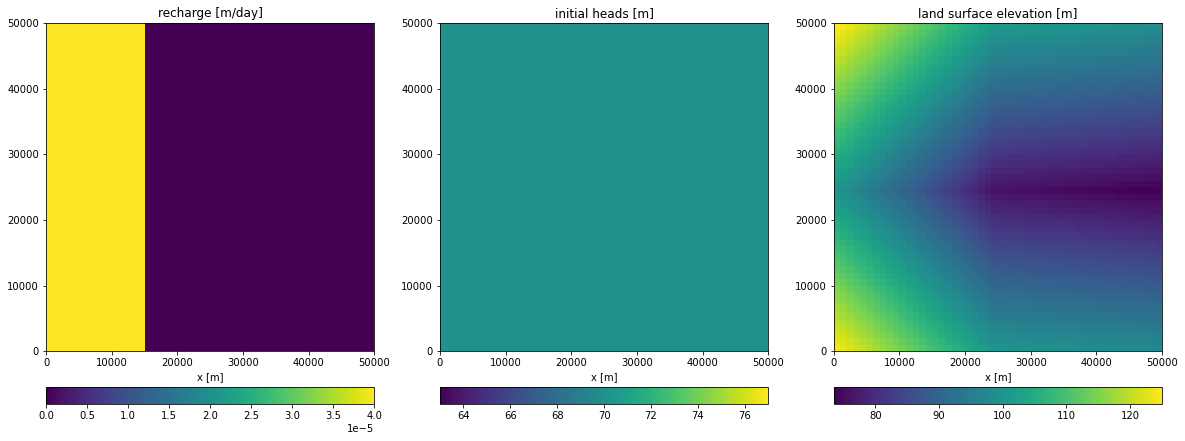

In [29]:
# Plot model setup with built-in FloPy tools
# note: this is for the top layer only!

#Set up axes
f,axes = plt.subplots(nrows=1,ncols=3,figsize=(20,15))  #create figure and axis objects with subplots for each parameter
maps = []                                               #create empty list to store maps of different model parameters
caxes = []                                              #create empty list to store different colorbar axes
for ax in axes:
    ax.set_aspect('equal') #set equal aspect ratio for all subplot axes
    m = flopy.plot.PlotMapView(model=mf, ax=ax, layer=0) #create map object
    ax.set_xlabel('x [m]')                               #set x axis label
    divider = make_axes_locatable(ax)                    #make axes dividable (to add colorbar)
    cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
    maps.append(m)                                            #add map object to list
    caxes.append(cax)                                         #add colorbar axis object to label
    

r = maps[0].plot_array(rech)
plt.colorbar(r, cax=caxes[0], orientation='horizontal')       #plot the colorbar
axes[0].set_title('recharge [m/day]')

h = maps[1].plot_array(strt[0,:,:])
plt.colorbar(h, cax=caxes[1], orientation='horizontal')       #plot the colorbar
axes[1].set_title('initial heads [m]')

h = maps[2].plot_array(ztop)
plt.colorbar(h, cax=caxes[2], orientation='horizontal')       #plot the colorbar
axes[2].set_title('land surface elevation [m]')

Text(0, 0.5, 'y [m]')

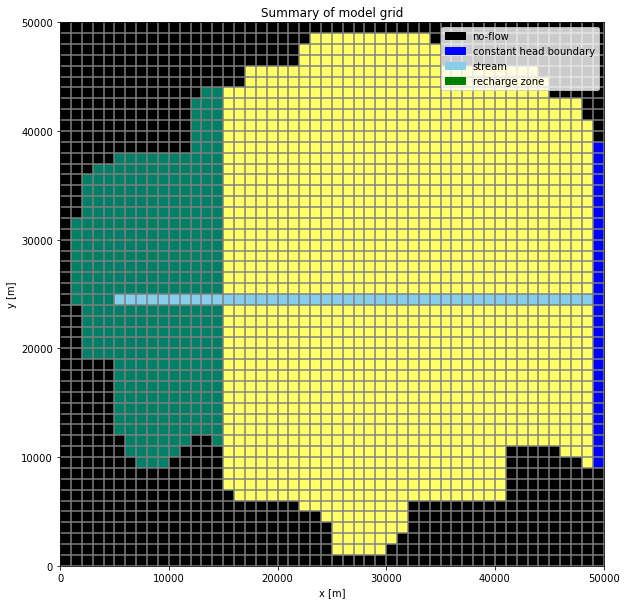

In [30]:
#Plot model boundary conditions summary:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Summary of model grid')                          #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
r = m.plot_array(rech, cmap='summer_r')                     #plot recharge array
bc = m.plot_ibound()                                        #plot boundary conditions
s = m.plot_bc("STR", color='skyblue')                       #plot stream

#Format and legend
plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                    matplotlib.patches.Patch(color='skyblue', label='stream'),
                    matplotlib.patches.Patch(color='green',label='recharge zone')])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

Text(0.5, 1.0, 'west-east cross-section')

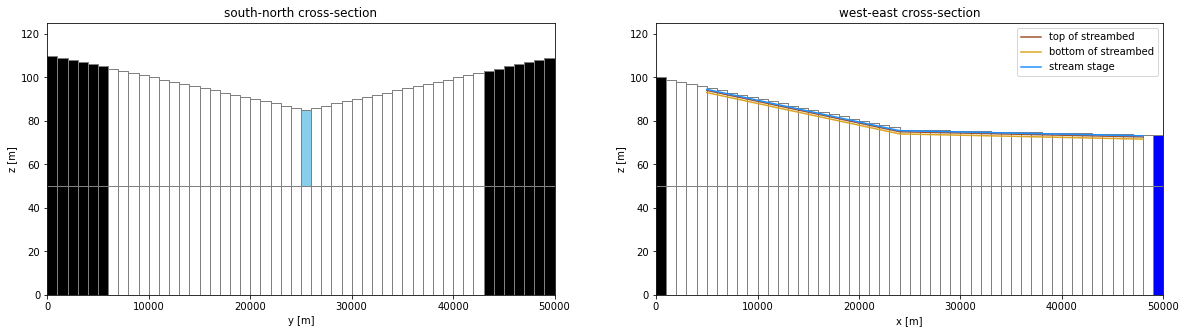

In [31]:
#Plot cross-section view of model:

#South-North:
f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 15})   #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
s  = xsec.plot_bc("STR", color='skyblue')                                    #plot stream
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

#East-West:
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': str_row})    #plot cross-ection along stream row
bc = xsec.plot_ibound()                                                         #plot boundary conditions
g  = xsec.plot_grid()                                                           #plot grid
st = ax[1].plot(str_cols*delc, str_top, c='sienna')                             #plot streambed top
sb = ax[1].plot(str_cols*delc, str_bot, c='goldenrod')                          #plot streambed top
sg = ax[1].plot(str_cols*delc, stage_elev, c='dodgerblue')                      #plot streambed top

plt.legend(handles=[matplotlib.lines.Line2D([],[], color='sienna', label='top of streambed'),
                    matplotlib.lines.Line2D([],[], color='goldenrod', label='bottom of streambed'),
                    matplotlib.lines.Line2D([],[], color='dodgerblue', label='stream stage'),]) #add legend manually
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

## Run model
The code in this section will change very little other than adding packages

In [32]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: stream.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/02/21 18:00:52

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/02/21 18:00:52
 Elapsed run time:  0.078 Seconds

  Normal termination of simulation


In [33]:
#Run MODPATH for particle tracking:
mp = flopy.modpath.Modpath6(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.Modpath6Bas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound, prsity=n)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH - you should see "Normal termination" printed below

FloPy is using the following executable to run the model: .\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

## Post-process and display results
Extract the raw output data and convert it into a format that's meaningful for humans

In [34]:
##Get outputs:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
stf = cbb.get_data(text='STREAM FLOW OUT ', totim=times[-1])[0]     #returns an array of flow rates in stream cells
stl = cbb.get_data(text='  STREAM LEAKAGE', totim=times[-1])[0]     #returns an array of leakage rates in stream cells

#Get MODPATH outputs: 
#load the endpoint data:
endobj = flopy.utils.EndpointFile(mp.sim.endpoint_file)   #get the raw MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array
        
#load the pathline data:
pthobj = flopy.utils.PathlineFile(mp.sim.pathline_file)
plines = pthobj.get_alldata()

In [35]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	        0.0
             RECHARGE_IN' 	    14120.0
       STREAM_LEAKAGE_IN' 	    6138.22
                TOTAL_IN' 	   20258.22
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	 -18110.795
            RECHARGE_OUT' 	       -0.0
      STREAM_LEAKAGE_OUT' 	 -2147.4253
               TOTAL_OUT' 	  -20258.22
                  IN-OUT' 	        0.0
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


#### Calibration ####
The "true" horizontal hydraulic conductivity is 21.5 m/day. <br>

With no stream: <br>
Piezometer 1: layer 0, row 12, col 42, H = 72.332 m <br>
Piezometer 2: layer 0, row 30, col 15, H = 78.599 m <br>

With stream: <br>
Piezometer 1: layer 0, row 12, col 42, H = 72.659 m <br>
Piezometer 2: layer 0, row 30, col 15, H = 80.629 m <br>

In [46]:
#Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

lay = 0                     #layer piezometer is in
row = 12                    #row piezometer is in
col = 42                    #column piezometer is in
h = head[lay,nrow-1-row,col]       #head at piezometer location

piezo = np.full((nlay,nrow,ncol), np.nan)  #create array of null values to be able to map piezometer
piezo[lay,nrow-1-row,col] = 1                     #mark the piezometer location with a 1

vmin = head_mx.min()                      #find the lowest head (excluding no-flow cells)
vmax = head_mx.max()                      #find the highest head (excluding no-flow cells)

text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places, add a tab before the last item)
print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values

text = 'Min. head: \t\t\t\t{} m \nMax. head: \t\t\t\t{:.3f} m'
print(text.format(vmin,vmax))

Head at layer 0, row 12, col 42: 	72.659 m
Min. head: 				70.0 m 
Max. head: 				82.629 m


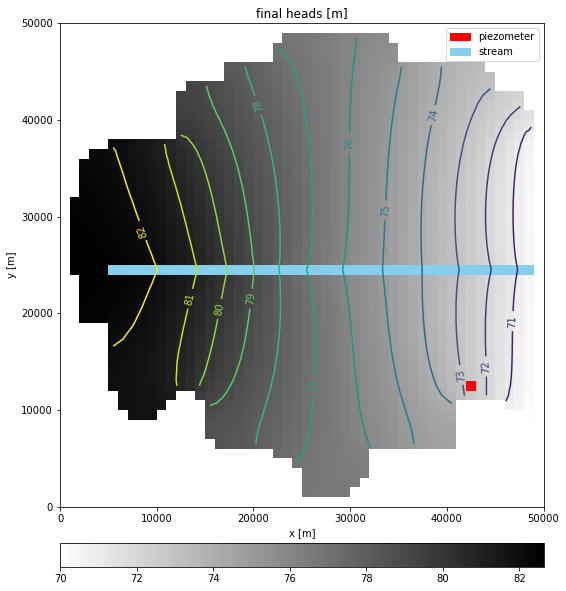

In [47]:
#Plot the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(10,10))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf)           #create flopy map object
h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 1)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, cmap='viridis') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
p = maps.plot_array(piezo, cmap='hsv')           #plot piezo
s = maps.plot_bc("STR", color='skyblue')            #plot stream


#Add legend and axis labels
plt.legend(handles=[matplotlib.patches.Patch(color='red',label='piezometer'),
                    matplotlib.patches.Patch(color='skyblue',label='stream')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')        #plot the colorbar

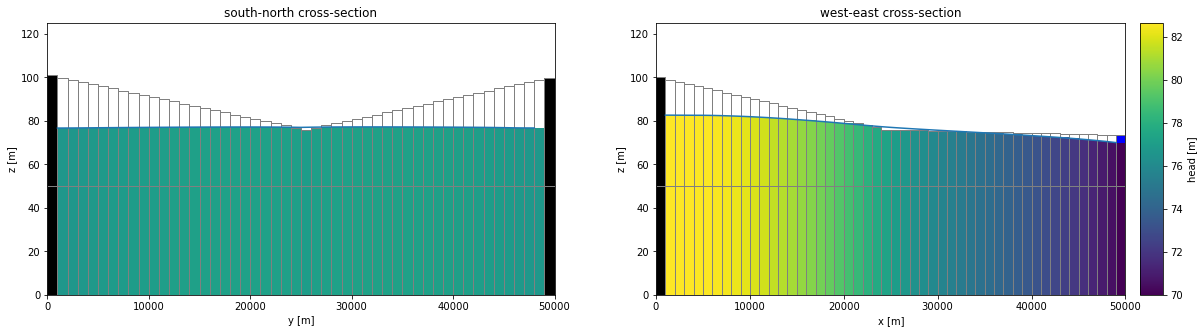

In [48]:
#Plot cross-section view of heads at center row and column:

f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 25})  #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)  #plot heads as an array, with color range set by min and max of full array
ax[0].plot(np.arange(0,Ly,delr), head_mx[0,:,25])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 25})      #plot cross-ection along given row
bc = xsec.plot_ibound()                                                      #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
ax[1].plot(np.arange(0,Lx,delc), head_mx[0,25,:])                            #plots heads as a line
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

#Add colorbar:
divider = make_axes_locatable(ax[1])                     #make axes dividable (to add colorbar)
cax = divider.append_axes('right', size="5%", pad=0.2)   #add an axis at the bottom for the colorbar
c = plt.colorbar(h, cax=cax, orientation='vertical')     #plot the colorbar
c.set_label('head [m]')                                  #label the colorbar

Text(0, 0.5, 'y [m]')

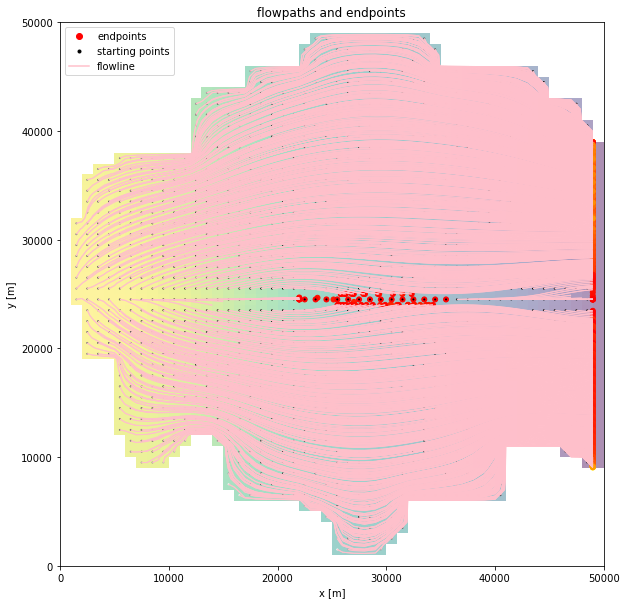

In [49]:
#Plot flowpath and endpoints:

f,ax = plt.subplots(1,1, figsize=(10, 10))              #make new figure and axes
ax.set_title('flowpaths and endpoints')
maps = flopy.plot.PlotMapView(model=mf)                 #make map object
h = maps.plot_array(head, masked_values=[-999.99], alpha=0.25) #plot heads as colors
#f = maps.plot_vector(frf, fff)                                #uncomment to plot vectors of flow direction in each cell
l = maps.plot_pathline(plines, layer=0, colors='pink', lw=1)   #uncomment to plot flowlines
e = maps.plot_endpoint(ept, cmap='autumn', s=5)                #plot endpoints of particles
e = maps.plot_endpoint(ept, direction='starting', cmap='binary_r', s=1)  #plot starting points of particles

plt.legend(handles=[matplotlib.lines.Line2D([],[], color='red', marker='o', linestyle='None', label='endpoints'),
                    matplotlib.lines.Line2D([],[], color='black', marker='.', linestyle='None', label='starting points'),
                    matplotlib.lines.Line2D([],[], color='pink',label='flowline')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

Text(0.5, 1.0, 'west-east cross-section')

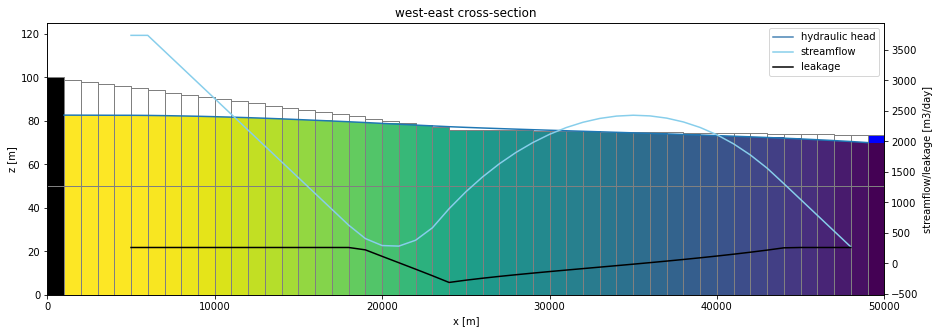

In [50]:
#Plot streamflow and leakage along stream:

#Extract streamflow & leakage data
strflows = np.zeros((nreach))       #create array of zeros the length of the stream
strleaks = np.zeros((nreach))       #create array of zeros the length of the stream
for i in np.arange(nreach):         #iterate over each reach
    strflows[i] = stf[i][1]         #get flow from stf array
    strleaks[i] = stl[i][1]         #get leakage from stl array

#Create figure & plot data:
f,ax = plt.subplots(1,1,figsize=(15,5))                                   #create figure object of width 15 in and height 5 in, with one subplot axis
xsec = flopy.plot.PlotCrossSection(model=mf, ax=ax, line={'Row': str_row})     #plot cross-ection along given row
bc = xsec.plot_ibound()                                                   #plot boundary conditions
h  = xsec.plot_array(head, masked_values=[-999.99], head=head, vmin=vmin, vmax=vmax)   #plot heads as array with same color range as above
hl = ax.plot(np.arange(0,Lx,delc), head_mx[0,str_row,:])                  #plots heads as a line
g  = xsec.plot_grid()                                                     #plot grid
ax2 = ax.twinx()                                                          #add a secondary y axis
f = ax2.plot(str_cols*delc, strflows, c='skyblue', label='streamflow')    #plot flows in each stream cell on second y axis
l = ax2.plot(str_cols*delc, strleaks, c='black', label='leakage')         #plot flows in each stream cell on second y axis

#Formatting:
plt.legend(handles=[matplotlib.lines.Line2D([],[], color='steelblue', label='hydraulic head'),
                    matplotlib.lines.Line2D([],[], color='skyblue', label='streamflow'),
                    matplotlib.lines.Line2D([],[], color='black', label='leakage')]) #add legend manually

ax.set_xlabel('x [m]')
ax.set_ylabel('z [m]')
ax2.set_ylabel('streamflow/leakage [m3/day]')     #label second y axis
ax.set_title('west-east cross-section')


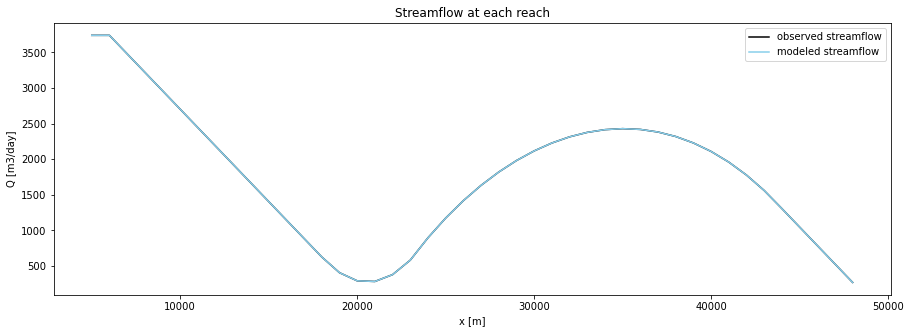

In [103]:
#Plot observed & modeled streamflow

obs = pd.read_csv('streamflows.csv', header=None, names=['x','Q'])  #import csv to a pandas dataframe
#print(obs)                                                          #this prints the dataframe - uncomment if you want to see what it looks like

f,ax = plt.subplots(1,1,figsize=(15,5))                             #create figure object of width 15 in and height 5 in, with one subplot axis
ax.plot(obs.x, obs.Q, c='k', label='observed streamflow')           #plot the column labeled x and the column labeled Q in the pandas dataframe called obs
ax.plot(str_cols*delc, strflows, c='skyblue', label='modeled streamflow')    #plot flows in each stream cell

ax.set_title('Streamflow at each reach')                            
ax.set_xlabel('x [m]')                                              
ax.set_ylabel('Q [m3/day]')
plt.legend()                                                        #add legend automatically using the labels defined during plotting

Kstream should be 173 m/day

In [109]:
#Calculate RMSE (m3/day) three different ways
rmse1 = np.sqrt(np.sum((strflows - obs.Q)**2)/len(strflows))
rmse2 = np.sqrt(np.mean((strflows-obs.Q)**2))
rmse3 = np.sqrt(((strflows - obs.Q) ** 2).mean())

print('RMSE: ',rmse1,' m3/day')

RMSE:  8.569467825559617e-15  m3/day


### Export data

In [105]:
np.savetxt('head_layer0.csv', head[0,:,:], delimiter=',')
np.savetxt('head_layer1.csv', head[1,:,:], delimiter=',')

In [106]:
sim =np.transpose([str_cols*delc, strflows])
np.savetxt('streamflows.csv', sim, delimiter=',')